# Installing the API/Introducing Raw Stats

In [2]:
!pip install nba_api

import requests
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import leaguegamefinder

# Let's focus on this szn only
gamefinder = leaguegamefinder.LeagueGameFinder(season_nullable='2024-25')
games = gamefinder.get_data_frames()[0]
#print(games.columns)
# I only want these columns
games = games[['TEAM_ID','GAME_ID','TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'MATCHUP', 'WL', 
               'PTS', 'REB','AST','TOV','FGA', 'FTA', 'OREB', 'MIN']]

#regular season only
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games = games[games['GAME_DATE'] >= '2024-10-22']



# List of NBA team IDs (standard across seasons)
nba_team_ids = [
    1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742,
    1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748,
    1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754,
    1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760,
    1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766
]

# Filter for NBA teams only with the team IDs I found online
nba_games = games[games['TEAM_ID'].isin(nba_team_ids)]

nba_games = nba_games.copy()

#Currently each game has 2 rows in the df but I think it only makes sense to have 1 row per game
nba_games['AWAY_ABBREVIATION'] = nba_games['MATCHUP'].str[-3:]
nba_games = nba_games[['TEAM_ID','GAME_ID','TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'MATCHUP', 'WL', 
                       'PTS', 'REB','AST','TOV', 'FGA', 'FTA', 'OREB', 'MIN']]


# Reset the index for cleaner display
nba_games.reset_index(drop=True, inplace=True)

# Filter for team 1 games
team1 = nba_games[nba_games['TEAM_ABBREVIATION'] == 'GSW']


# Filter for team 2 games
team2 = nba_games[nba_games['TEAM_NAME'] == 'Houston Rockets']



# Calculate average points from last 10 games
average_points_team1 = team1['PTS'].iloc[:20].mean()
average_points_team2 = team2['PTS'].iloc[:20].mean()
total_average_pts = average_points_team1 + average_points_team2

print("This team 2's 20-game average points are:", (average_points_team1))
print("This team 2's 20-game average points are:", round(average_points_team2))
print("Sum of these 2 teams' 20-game moving averages:", (total_average_pts))

# Display the first 10 rows

#team1.tail(15)
#print(team2.head(10))








This team 2's 20-game average points are: 111.5
This team 2's 20-game average points are: 113
Sum of these 2 teams' 20-game moving averages: 224.3


# Possession and Pace Metrics

In [4]:
# made an @ matchup df so I could join it with the orginal and get opponents points
nba_at_games = nba_games[nba_games['MATCHUP'].str.contains('@')]
nba_at_games = nba_at_games[['GAME_ID', 'PTS', 'REB', 'AST', 'TOV','FGA', 'FTA', 'OREB', 'MIN']]

#lets merge and clean data
games_merge = nba_games.merge(nba_at_games, on = 'GAME_ID', how = 'left')
games_merge = games_merge.rename(columns = {'TEAM_ABBREVIATION':'HOME','AWAY_ABBREVIATION': 'AWAY',	'PTS_x': 'H_PTS', 'PTS_y': 'A_PTS', 
                                            'REB_x': 'H_REB', 'REB_y':'A_REB', 'AST_x':'H_AST','AST_y':'A_AST',
                                           'TOV_x':'H_TOV', 'TOV_y':'A_TOV', 'FGA_x':'H_FGA', 'FGA_y':'A_FGA', 'FTA_x':'H_FTA', 'FTA_y':'A_FTA',
                                           'OREB_x':'H_OREB', 'OREB_y':'A_OREB', 'MIN_x': 'MIN'})
games_merge = games_merge.drop(columns = {'MIN_y'})
games_merge['MIN'] = games_merge['MIN']/5
# This will be our target variable
games_merge['TOTAL_POINTS'] = games_merge['H_PTS']+ games_merge['A_PTS']

games_merge['AWAY'] = games_merge['MATCHUP'].str[-3:]
# making possession metric
games_merge['H_POSS'] = games_merge['H_FGA'] + (0.44 * games_merge['H_FTA']) - games_merge['H_OREB'] + games_merge['H_TOV']
games_merge['A_POSS'] = games_merge['A_FGA'] + (0.44 * games_merge['A_FTA']) - games_merge['A_OREB'] + games_merge['A_TOV']

#have to correct the 'min' column for accuracy
games_merge.loc[(games_merge['MIN'] <= 49), 'MIN'] = 48
games_merge.loc[((games_merge['MIN'] > 53) & (games_merge['MIN'] < 54) ), 'MIN'] = 53

#making pace metric from possession
games_merge['H_PACE'] = (games_merge['H_POSS']/games_merge['MIN'])*48
games_merge['A_PACE'] = (games_merge['A_POSS']/games_merge['MIN'])*48

games_merge = games_merge[games_merge['MATCHUP'].str.contains('vs.')].reset_index(drop=True)

games_merge.head()


,TEAM_ID,GAME_ID,HOME,TEAM_NAME,GAME_DATE,MATCHUP,WL,H_PTS,H_REB,H_AST,...,A_TOV,A_FGA,A_FTA,A_OREB,TOTAL_POINTS,AWAY,H_POSS,A_POSS,H_PACE,A_PACE
0,1610612738,0042400212,BOS,Boston Celtics,2025-05-07,BOS vs. NYK,L,90,51,17,...,15,86,10,10,181,NYK,100.60,95.40,100.600000,95.400000
1,1610612760,0042400222,OKC,Oklahoma City Thunder,2025-05-07,OKC vs. DEN,W,149,44,31,...,20,87,32,13,255,DEN,105.84,108.08,105.840000,108.080000
2,1610612739,0042400202,CLE,Cleveland Cavaliers,2025-05-06,CLE vs. IND,L,119,43,24,...,17,85,29,11,239,IND,104.40,103.76,104.400000,103.760000
3,1610612750,0042400231,MIN,Minnesota Timberwolves,2025-05-06,MIN vs. GSW,L,88,41,19,...,12,87,15,18,187,GSW,97.48,87.60,97.480000,87.600000
4,1610612738,0042400211,BOS,Boston Celtics,2025-05-05,BOS vs. NYK,L,105,59,18,...,12,87,31,12,213,NYK,102.44,100.64,93.127273,91.490909


# Rolling Averages for Key Stats

In [6]:
# Combine home and away game stats for each team
games_combined = pd.concat(
    [
        games_merge[['GAME_DATE', 'HOME', 'H_PTS', 'H_REB', 'H_AST', 'H_TOV', 'H_PACE']]
        .rename(columns={'HOME': 'TEAMS', 'H_PTS': 'PTS', 'H_REB': 'REB', 'H_AST': 'AST', 'H_TOV': 'TOV',
                        'H_PACE' : 'PACE'}),
        
        games_merge[['GAME_DATE', 'AWAY', 'A_PTS', 'A_REB', 'A_AST', 'A_TOV', 'A_PACE']]
        .rename(columns={'AWAY': 'TEAMS', 'A_PTS': 'PTS', 'A_REB': 'REB', 'A_AST': 'AST', 'A_TOV': 'TOV',
                        'A_PACE' : 'PACE'})
    ]
)

# Sort by team and game date to ensure chronological order
games_combined = games_combined.sort_values(by=['TEAMS', 'GAME_DATE'], ascending=[True, True])

# Calculate 10-game moving average for multiple columns and apply a lag of 1 because I don't want the model to be future-looking
for col in ['PTS', 'REB', 'AST', 'TOV', 'PACE']:
    games_combined[f'AVG_{col}_LAST_10'] = (
        games_combined.groupby('TEAMS')[col]
        .transform(lambda x: x.shift(1).rolling(window=20, min_periods=1).mean())
    )


games_combined['AVG_PTS_LAST_3'] = (
    games_combined.groupby('TEAMS')['PTS']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
)

# Ensure only relevant columns before merging
games_combined = games_combined[['GAME_DATE', 'TEAMS', 'PTS', 'AVG_PTS_LAST_10', 'AVG_REB_LAST_10', 'AVG_AST_LAST_10', 'AVG_TOV_LAST_10', 'AVG_PACE_LAST_10',
                                'AVG_PTS_LAST_3']]

# Drop duplicate columns if they exist before merging
games_merge.drop(columns=[col for col in ['AVG_PTS_LAST_10', 'AVG_PTS_LAST_3','AVG_REB_LAST_10', 'AVG_AST_LAST_10', 'AVG_TOV_LAST_10','AVG_PACE_LAST_10', 'TEAMS', 'TEAM_x', 'TEAM_y'] if col in games_merge.columns], inplace=True)

# Merge home team average stats
games_merge = games_merge.merge(
    games_combined,
    left_on=['GAME_DATE', 'HOME'],
    right_on=['GAME_DATE', 'TEAMS'],
    how='left'
)

# Rename columns to reflect home team stats
games_merge.rename(columns={
    'AVG_PTS_LAST_10': 'H_AVG_PTS_L20',
    'AVG_REB_LAST_10': 'H_AVG_REB_L20',
    'AVG_AST_LAST_10': 'H_AVG_AST_L20',
    'AVG_TOV_LAST_10': 'H_AVG_TOV_L20',
    'AVG_PACE_LAST_10': 'H_AVG_PACE_L20',
    'AVG_PTS_LAST_3' : 'H_AVG_PTS_L3'
}, inplace=True)

# Drop unnecessary columns post-merge
games_merge.drop(columns=['TEAMS'], inplace=True)

# Merge away team average stats
games_merge = games_merge.merge(
    games_combined,
    left_on=['GAME_DATE', 'AWAY'],
    right_on=['GAME_DATE', 'TEAMS'],
    how='left'
)

# Rename columns to reflect away team stats
games_merge.rename(columns={
    'AVG_PTS_LAST_10': 'A_AVG_PTS_L20',
    'AVG_REB_LAST_10': 'A_AVG_REB_L20',
    'AVG_AST_LAST_10': 'A_AVG_AST_L20',
    'AVG_TOV_LAST_10': 'A_AVG_TOV_L20',
    'AVG_PACE_LAST_10': 'A_AVG_PACE_L20',
     'AVG_PTS_LAST_3' : 'A_AVG_PTS_L3'
}, inplace=True)

# Drop unnecessary columns post-merge
games_merge.drop(columns=['TEAMS'], inplace=True)

# Remove duplicate columns if any exist
games_merge = games_merge.loc[:, ~games_merge.columns.duplicated()]

# Round values for better readability
for col in ['H_AVG_PTS_L20', 'A_AVG_PTS_L20', 'H_AVG_REB_L20', 'A_AVG_REB_L20',
            'H_AVG_AST_L20', 'A_AVG_AST_L20', 'H_AVG_TOV_L20', 'A_AVG_TOV_L20',
           'H_AVG_PACE_L20', 'A_AVG_PACE_L20']:
    games_merge[col] = games_merge[col].round(1)
games_merge['TOTAL_AVG_PTS'] = games_merge['H_AVG_PTS_L20'] + games_merge['A_AVG_PTS_L20']
games_merge = games_merge.drop(columns = {'H_REB', 'H_AST','H_TOV', 'A_REB', 'A_AST','A_TOV'})

# I can make games today table here and recall it in a later kernel.
games_unfinished = games_merge[games_merge['WL'].isna()]

#This is where I exclude ongoing games. I only want finished games
games_merge = games_merge[games_merge['WL'].notna()]
# Display updated DataFrame
#games_merge.head(10)

games_merge_nyk = games_merge[(games_merge['HOME'] == 'LAL')|(games_merge['AWAY'] == 'LAL') ]

games_merge_nyk[['GAME_DATE','HOME','AWAY', 'H_PTS', 'A_PTS','H_AVG_PTS_L3','A_AVG_PTS_L3']].head(8)

#games_combined.head()

,GAME_DATE,HOME,AWAY,H_PTS,A_PTS,H_AVG_PTS_L3,A_AVG_PTS_L3
12,2025-04-30,LAL,MIN,96,103,103.666667,105.666667
21,2025-04-27,MIN,LAL,116,113,106.000000,97.666667
29,2025-04-25,MIN,LAL,116,104,106.000000,90.000000
39,2025-04-22,LAL,MIN,94,85,105.333333,116.666667
47,2025-04-19,LAL,MIN,95,117,111.000000,124.666667
60,2025-04-13,POR,LAL,109,81,110.666667,124.000000
84,2025-04-11,LAL,HOU,140,109,119.333333,116.000000
91,2025-04-09,DAL,LAL,97,112,105.000000,123.333333


# Defensive Rolling Averages

In [8]:
# The purpose of this kernel is to find defensive rolling averages to include into the model
# Step 1: Calculate Points Allowed for Each Team
games_combine = pd.concat([
    games_merge[['GAME_DATE', 'HOME', 'A_PTS']].rename(columns={'HOME': 'TEAM', 'A_PTS': 'PTS_ALLOWED'}),
    games_merge[['GAME_DATE', 'AWAY', 'H_PTS']].rename(columns={'AWAY': 'TEAM', 'H_PTS': 'PTS_ALLOWED'})
])

# Step 2: Ensure chronological order
games_combine = games_combine.sort_values(by=['TEAM', 'GAME_DATE'], ascending=[True, True])

# Step 3: Calculate 10-game Defensive Average (rolling mean)
games_combine['DEF_AVG_L20'] = (
    games_combine.groupby('TEAM')['PTS_ALLOWED']
    .transform(lambda x: x.shift(1).rolling(window=20, min_periods=1).mean())
)

# Step 4: Merge Defensive Averages Back for Home Teams
games_merge = games_merge.merge(
    games_combine[['GAME_DATE', 'TEAM', 'DEF_AVG_L20']],
    left_on=['GAME_DATE', 'HOME'],
    right_on=['GAME_DATE', 'TEAM'],
    how='left'
).rename(columns={'DEF_AVG_L20': 'H_DEF_AVG_L20'})

games_merge.drop(columns=['TEAM'], inplace=True)  # Clean up after merge

# Step 5: Merge Defensive Averages Back for Away Teams
games_merge = games_merge.merge(
    games_combine[['GAME_DATE', 'TEAM', 'DEF_AVG_L20']],
    left_on=['GAME_DATE', 'AWAY'],
    right_on=['GAME_DATE', 'TEAM'],
    how='left'
).rename(columns={'DEF_AVG_L20': 'A_DEF_AVG_L20'})

games_merge.drop(columns=['TEAM'], inplace=True)  # Clean up after merge


# Check the results
games_merge[['GAME_DATE', 'HOME', 'AWAY', 'H_DEF_AVG_L20', 'A_DEF_AVG_L20']].head()






,GAME_DATE,HOME,AWAY,H_DEF_AVG_L20,A_DEF_AVG_L20
0,2025-05-07,BOS,NYK,100.40,107.60
1,2025-05-07,OKC,DEN,108.45,114.35
2,2025-05-06,CLE,IND,112.35,111.60
3,2025-05-06,MIN,GSW,108.00,107.55
4,2025-05-05,BOS,NYK,100.65,108.10


# Correlation Matrix

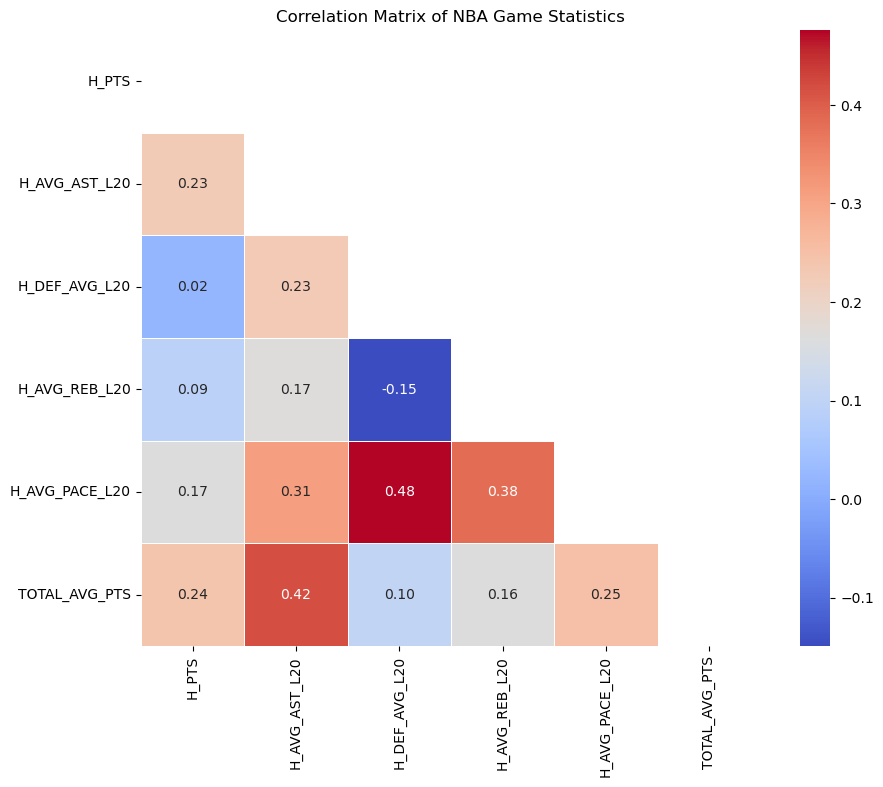

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


# Compute the correlation matrix
correlation_matrix = games_merge[[ 'H_PTS', 'H_AVG_AST_L20', 'H_DEF_AVG_L20','H_AVG_REB_L20', 'H_AVG_PACE_L20','TOTAL_AVG_PTS']].corr()

# Mask the upper triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

#Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask = mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of NBA Game Statistics')
plt.show()


# Winning Streaks

In [12]:
import numpy as np

games_merge_was = games_merge[['GAME_DATE','HOME','AWAY','H_PTS','A_PTS','WL']]

# Make an explicit copy to avoid SettingWithCopyWarning
games_merge_was = games_merge[['GAME_DATE', 'HOME', 'AWAY', 'H_PTS', 'A_PTS', 'WL']].copy()

# Use .loc to modify the column explicitly
games_merge_was.loc[:, 'A_WL'] = games_merge_was.apply(
    lambda row: 'W' if row['A_PTS'] > row['H_PTS'] else 'L', axis=1
)


home_results = games_merge_was[['GAME_DATE','HOME','H_PTS','WL']]
away_results = games_merge_was[['GAME_DATE','AWAY','A_PTS','A_WL']]

home_results = home_results.rename(columns = {'HOME':'TEAM','H_PTS':'PTS'})
away_results = away_results.rename(columns = {'AWAY':'TEAM','A_PTS':'PTS', 'A_WL':'WL'})

long_form = pd.concat([home_results , away_results], axis=0) 
long_form = long_form.sort_values(by = ['TEAM','GAME_DATE'],ascending = [False,True])

# I can use a 'def' function to calculate current streak
def streak (results):
    streaks = []
    streak = 0

    for result in results:
        if result == 'W':
            streak = streak + 1 if streak > 0 else 1
        elif result == 'L':
            streak = streak - 1 if streak < 0 else -1
        else:
            streak = 0
        streaks.append(streak)
    return streaks
    
long_form['TEAM_WIN_LOSS_STREAK'] = (
    long_form.groupby('TEAM')['WL']
    .transform(lambda x: streak(x))
)

long_form['TEAM_WIN_LOSS_STREAK'] = (
    long_form.groupby('TEAM')['TEAM_WIN_LOSS_STREAK']
    .shift(1)
    .fillna(0)  # If first game, set to 0
)





games_merge = games_merge.merge(long_form[['GAME_DATE', 'TEAM', 'TEAM_WIN_LOSS_STREAK']], 
                                               left_on = ['GAME_DATE', 'HOME'],
                                               right_on=['GAME_DATE', 'TEAM'],
                                               how='left').rename(columns={'TEAM_WIN_LOSS_STREAK': 'HOME_WIN_STREAK'}).drop(columns=['TEAM'])
games_merge = games_merge.merge(long_form[['GAME_DATE', 'TEAM', 'TEAM_WIN_LOSS_STREAK']], 
                                               left_on = ['GAME_DATE', 'AWAY'],
                                               right_on=['GAME_DATE', 'TEAM'],
                                               how='left').rename(columns={'TEAM_WIN_LOSS_STREAK': 'AWAY_WIN_STREAK'}).drop(columns=['TEAM'])
games_merge.head()

,TEAM_ID,GAME_ID,HOME,TEAM_NAME,GAME_DATE,MATCHUP,WL,H_PTS,H_FGA,H_FTA,...,A_AVG_REB_L20,A_AVG_AST_L20,A_AVG_TOV_L20,A_AVG_PACE_L20,A_AVG_PTS_L3,TOTAL_AVG_PTS,H_DEF_AVG_L20,A_DEF_AVG_L20,HOME_WIN_STREAK,AWAY_WIN_STREAK
0,1610612738,0042400212,BOS,Boston Celtics,2025-05-07,BOS vs. NYK,L,90,94,15,...,41.2,25.6,12.2,97.6,109.000000,223.4,100.40,107.60,-1.0,2.0
1,1610612760,0042400222,OKC,Oklahoma City Thunder,2025-05-07,OKC vs. DEN,W,149,89,36,...,45.8,27.9,13.6,98.6,115.333333,239.1,108.45,114.35,-1.0,2.0
2,1610612739,0042400202,CLE,Cleveland Cavaliers,2025-05-06,CLE vs. IND,L,119,90,35,...,44.8,29.8,11.0,99.6,123.000000,239.6,112.35,111.60,-1.0,3.0
3,1610612750,0042400231,MIN,Minnesota Timberwolves,2025-05-06,MIN vs. GSW,L,88,86,17,...,41.8,27.4,12.2,97.3,108.666667,229.7,108.00,107.55,3.0,1.0
4,1610612738,0042400211,BOS,Boston Celtics,2025-05-05,BOS vs. NYK,L,105,97,26,...,40.6,26.0,12.0,97.9,104.333333,223.4,100.65,108.10,2.0,1.0


# Win Percentages

In [14]:
import pandas as pd
import numpy as np

# Ensure 'WL' is a string column
long_form['WL'] = long_form['WL'].astype(str)

# Ensure DataFrame is sorted by date before rolling calculations
long_form = long_form.sort_values(by=['TEAM', 'GAME_DATE'], ascending=[True, True])

# Define rolling win percentage function
def rolling_win_pct(series, window=10):
    rolling_wins = series.eq('W').rolling(window, min_periods=1).sum()  # Compute wins
    rolling_counts = series.rolling(window, min_periods=1).count()  # Total games played
    return rolling_wins / rolling_counts  # Adjusts denominator dynamically

# Apply rolling function to each team
long_form['TEAM_WPCT_L10'] = (
    long_form.groupby('TEAM')['WL']
    .transform(lambda x: rolling_win_pct(x, window=10))
    .shift(1)  # Lag by 1 game
    .round(3)
)
long_form['TEAM_WPCT_L10'] = long_form['TEAM_WPCT_L10'].fillna(0.500)

games_merge = games_merge.merge(
    long_form[['TEAM', 'GAME_DATE', 'TEAM_WPCT_L10']],  # Only keep necessary columns
    how='left',  # Keep all rows from games_merge
    left_on=['HOME', 'GAME_DATE'],  # Match home teams
    right_on=['TEAM', 'GAME_DATE']
).rename(columns={'TEAM_WPCT_L10': 'HOME_WPCT_L10'})  # Rename for clarity

# Drop the duplicate 'TEAM' column after merge
games_merge.drop(columns=['TEAM'], inplace=True)

# Repeat for AWAY teams
games_merge = games_merge.merge(
    long_form[['TEAM', 'GAME_DATE', 'TEAM_WPCT_L10']], 
    how='left', 
    left_on=['AWAY', 'GAME_DATE'],  # Match away teams
    right_on=['TEAM', 'GAME_DATE']
).rename(columns={'TEAM_WPCT_L10': 'AWAY_WPCT_L10'}) 

# Drop the duplicate 'TEAM' column after merge
games_merge.drop(columns=['TEAM'], inplace=True)
pd.set_option('display.float_format', '{:.3f}'.format)  # Show 4 decimal places
games_merge[['HOME_WPCT_L10', 'AWAY_WPCT_L10']] = games_merge[['HOME_WPCT_L10', 'AWAY_WPCT_L10']].astype(float)

games_merge.head()  # Check data types




,TEAM_ID,GAME_ID,HOME,TEAM_NAME,GAME_DATE,MATCHUP,WL,H_PTS,H_FGA,H_FTA,...,A_AVG_TOV_L20,A_AVG_PACE_L20,A_AVG_PTS_L3,TOTAL_AVG_PTS,H_DEF_AVG_L20,A_DEF_AVG_L20,HOME_WIN_STREAK,AWAY_WIN_STREAK,HOME_WPCT_L10,AWAY_WPCT_L10
0,1610612738,0042400212,BOS,Boston Celtics,2025-05-07,BOS vs. NYK,L,90,94,15,...,12.200,97.600,109.000,223.400,100.400,107.600,-1.000,2.000,0.700,0.600
1,1610612760,0042400222,OKC,Oklahoma City Thunder,2025-05-07,OKC vs. DEN,W,149,89,36,...,13.600,98.600,115.333,239.100,108.450,114.350,-1.000,2.000,0.800,0.700
2,1610612739,0042400202,CLE,Cleveland Cavaliers,2025-05-06,CLE vs. IND,L,119,90,35,...,11.000,99.600,123.000,239.600,112.350,111.600,-1.000,3.000,0.600,0.800
3,1610612750,0042400231,MIN,Minnesota Timberwolves,2025-05-06,MIN vs. GSW,L,88,86,17,...,12.200,97.300,108.667,229.700,108.000,107.550,3.000,1.000,0.800,0.600
4,1610612738,0042400211,BOS,Boston Celtics,2025-05-05,BOS vs. NYK,L,105,97,26,...,12.000,97.900,104.333,223.400,100.650,108.100,2.000,1.000,0.800,0.500


# Rest Days

In [16]:
import pandas as pd

# Step 1: Create long format dataset with each team separately listed
home_games = games_merge[['GAME_DATE', 'HOME']].rename(columns={'HOME': 'TEAM'})
away_games = games_merge[['GAME_DATE', 'AWAY']].rename(columns={'AWAY': 'TEAM'})

long_format = pd.concat([home_games, away_games], axis=0).sort_values(by=['TEAM', 'GAME_DATE'])

# Convert GAME_DATE to datetime format
long_format['GAME_DATE'] = pd.to_datetime(long_format['GAME_DATE'])

# Step 2: Calculate the number of days since last game for each team
long_format['LAST_GAME_DATE'] = long_format.groupby('TEAM')['GAME_DATE'].shift(1)
long_format['REST_DAYS'] = (long_format['GAME_DATE'] - long_format['LAST_GAME_DATE']).dt.days.fillna(7)  # Assume 7 if no prior game

# Step 3: Merge back to the main dataset
games_merge = games_merge.merge(long_format[['GAME_DATE', 'TEAM', 'REST_DAYS']], 
                                left_on=['GAME_DATE', 'HOME'], 
                                right_on=['GAME_DATE', 'TEAM'], 
                                how='left').rename(columns={'REST_DAYS': 'HOME_REST_DAYS'}).drop(columns=['TEAM'])

games_merge = games_merge.merge(long_format[['GAME_DATE', 'TEAM', 'REST_DAYS']], 
                                left_on=['GAME_DATE', 'AWAY'], 
                                right_on=['GAME_DATE', 'TEAM'], 
                                how='left').rename(columns={'REST_DAYS': 'AWAY_REST_DAYS'}).drop(columns=['TEAM'])

# Check the results
games_merge[['GAME_DATE', 'HOME', 'AWAY', 'HOME_REST_DAYS', 'AWAY_REST_DAYS']].head(10)


,GAME_DATE,HOME,AWAY,HOME_REST_DAYS,AWAY_REST_DAYS
0,2025-05-07,BOS,NYK,2.000,2.000
1,2025-05-07,OKC,DEN,2.000,2.000
2,2025-05-06,CLE,IND,2.000,2.000
3,2025-05-06,MIN,GSW,6.000,2.000
4,2025-05-05,BOS,NYK,6.000,4.000
5,2025-05-05,OKC,DEN,9.000,2.000
6,2025-05-04,CLE,IND,6.000,5.000
7,2025-05-04,HOU,GSW,2.000,2.000
8,2025-05-03,DEN,LAC,2.000,2.000
9,2025-05-02,GSW,HOU,2.000,2.000


# Head-to-Head Matchup Feature

In [18]:
# Step 1: Create sorted team pair to represent matchup regardless of order
games_merge['TEAM_PAIR'] = games_merge.apply(
    lambda row: tuple(sorted([row['HOME'], row['AWAY']])), axis=1
)

# Step 2: Group by that pair
h2h_avgs = games_merge.groupby('TEAM_PAIR')['TOTAL_POINTS'].mean().reset_index()
h2h_avgs.rename(columns={'TOTAL_POINTS': 'H2H_AVG_TOTAL'}, inplace=True)

# Step 3: Merge back
games_merge = games_merge.merge(h2h_avgs, on='TEAM_PAIR', how='left')

# Check it worked:




games_merge['IS_PLAYOFF'] = games_merge['GAME_DATE'] >= pd.to_datetime('2025-04-19')

games_merge[['HOME', 'AWAY', 'TOTAL_POINTS', 'H2H_AVG_TOTAL','IS_PLAYOFF']].head(10)



,HOME,AWAY,TOTAL_POINTS,H2H_AVG_TOTAL,IS_PLAYOFF
0,BOS,NYK,181,221.500,True
1,OKC,DEN,255,237.833,True
2,CLE,IND,239,231.167,True
3,MIN,GSW,187,210.200,True
4,BOS,NYK,213,221.500,True
5,OKC,DEN,240,237.833,True
6,CLE,IND,233,231.167,True
7,HOU,GSW,192,206.833,True
8,DEN,LAC,221,220.000,True
9,GSW,HOU,222,206.833,True


# Pulling from TeamStats Rank

In [20]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time


# Path to your chromedriver
chrome_driver_path = r"C:\Users\owner\Downloads\chromedriver-win64 (1)\chromedriver-win64\chromedriver.exe"

service = Service(chrome_driver_path)
options = webdriver.ChromeOptions()
#options.add_argument("--headless")  # Run without UI
driver = webdriver.Chrome(service=service, options=options)

# Load the page
url = "https://www.teamrankings.com/nba/stat/points-per-game"

driver.get(url)
time.sleep(5)  # Add this before the wait
wait = WebDriverWait(driver, 15)
wait.until(EC.presence_of_element_located((By.ID, "DataTables_Table_0")))


# Locate the rows
rows = driver.find_elements(By.CSS_SELECTOR, "#DataTables_Table_0 tbody tr")

# Extract the data
data = []
for row in rows:
    cells = row.find_elements(By.TAG_NAME, "td")
    if cells:
        row_data = [cell.text for cell in cells]
        data.append(row_data)

# Convert to DataFrame
columns = ['Rank', 'Team', '2024', 'Last 3', 'Last 1', 'Home', 'Away', '2023']
df = pd.DataFrame(data, columns=columns)

driver.quit()

team_abbreviations = {
    "Atlanta": "ATL",
    "Boston": "BOS",
    "Brooklyn": "BKN",
    "Charlotte": "CHA",
    "Chicago": "CHI",
    "Cleveland": "CLE",
    "Dallas": "DAL",
    "Denver": "DEN",
    "Detroit": "DET",
    "Golden State": "GSW",
    "Houston": "HOU",
    "Indiana": "IND",
    "LA Clippers": "LAC",
    "LA Lakers": "LAL",
    "Memphis": "MEM",
    "Miami": "MIA",
    "Milwaukee": "MIL",
    "Minnesota": "MIN",
    "New Orleans": "NOP",
    "New York": "NYK",
    "Okla City": "OKC",
    "Orlando": "ORL",
    "Philadelphia": "PHI",
    "Phoenix": "PHX",
    "Portland": "POR",
    "Sacramento": "SAC",
    "San Antonio": "SAS",
    "Toronto": "TOR",
    "Utah": "UTA",
    "Washington": "WAS"
}

df["Abbreviation"] = df["Team"].map(team_abbreviations)


team_avgs = df[['Abbreviation','Home','Away']]



team_avgs.head(30)

,Abbreviation,Home,Away
0,CLE,122.3,121.7
1,MEM,122.8,118.5
2,OKC,123.4,117.2
3,DEN,122.2,117.1
4,ATL,118.1,117.6
5,CHI,115.9,119.0
6,IND,118.5,116.5
7,SAC,115.8,115.4
8,BOS,115.7,114.9
9,MIL,118.3,111.9


# Merging scraped team stats into games merge table

In [22]:
# Set index to the abbreviation for easier merging
team_avgs = team_avgs.set_index("Abbreviation")

# Merge HOME scoring average
games_merge = games_merge.merge(
    team_avgs[["Home"]].rename(columns={"Home": "HOME_SZN_AVG"}),
    how="left",
    left_on="HOME",
    right_index=True
)

# Merge AWAY scoring average
games_merge = games_merge.merge(
    team_avgs[["Away"]].rename(columns={"Away": "AWAY_SZN_AVG"}),
    how="left",
    left_on="AWAY",
    right_index=True
)
games_merge.head()

,TEAM_ID,GAME_ID,HOME,TEAM_NAME,GAME_DATE,MATCHUP,WL,H_PTS,H_FGA,H_FTA,...,AWAY_WIN_STREAK,HOME_WPCT_L10,AWAY_WPCT_L10,HOME_REST_DAYS,AWAY_REST_DAYS,TEAM_PAIR,H2H_AVG_TOTAL,IS_PLAYOFF,HOME_SZN_AVG,AWAY_SZN_AVG
0,1610612738,0042400212,BOS,Boston Celtics,2025-05-07,BOS vs. NYK,L,90,94,15,...,2.000,0.700,0.600,2.000,2.000,"(BOS, NYK)",221.500,True,115.7,113.1
1,1610612760,0042400222,OKC,Oklahoma City Thunder,2025-05-07,OKC vs. DEN,W,149,89,36,...,2.000,0.800,0.700,2.000,2.000,"(DEN, OKC)",237.833,True,123.4,117.1
2,1610612739,0042400202,CLE,Cleveland Cavaliers,2025-05-06,CLE vs. IND,L,119,90,35,...,3.000,0.600,0.800,2.000,2.000,"(CLE, IND)",231.167,True,122.3,116.5
3,1610612750,0042400231,MIN,Minnesota Timberwolves,2025-05-06,MIN vs. GSW,L,88,86,17,...,1.000,0.800,0.600,6.000,2.000,"(GSW, MIN)",210.200,True,115.1,113.6
4,1610612738,0042400211,BOS,Boston Celtics,2025-05-05,BOS vs. NYK,L,105,97,26,...,1.000,0.800,0.500,6.000,4.000,"(BOS, NYK)",221.500,True,115.7,113.1


In [23]:
!pip install requests beautifulsoup4 pandas

def scrape_teamrankings_avg(target_date):
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service
    from selenium.webdriver.common.by import By
    from selenium.webdriver.chrome.options import Options
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    import pandas as pd
    import time

    url = f"https://www.teamrankings.com/nba/stat/points-per-game?date={target_date}"

    # Setup Chrome options
    options = Options()
    options.add_argument('--headless')
    
    chrome_driver_path = r"C:\Users\owner\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe"

    service = Service(chrome_driver_path)

    from datetime import datetime, timedelta

    driver = webdriver.Chrome(service=service, options=options)
    driver.get(url)

    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "DataTables_Table_0"))
        )
        rows = driver.find_elements(By.CSS_SELECTOR, "#DataTables_Table_0 tbody tr")
        data = []
        for row in rows:
            cells = row.find_elements(By.TAG_NAME, "td")
            data.append([cell.text for cell in cells])

        driver.quit()

        df = pd.DataFrame(data, columns=[
            "Rank", "Team", "2024", "Last 3", "Last 1", "Home", "Away", "2023"
        ])
        df["Date"] = target_date
        return df

    except Exception as e:
        driver.quit()
        print(f"Error scraping {target_date}: {e}")
        return None


# Regression Testing

(1265, 33)
Mean Absolute Error (MAE): 11.40
Mean Squared Error (MSE): 219.32
Root Mean Squared Error (RMSE): 14.81
R-Squared (R²): 0.453
                       Coefficient
TOTAL_AVG_PTS                0.023
TOTAL_PTS_ALLOWED_L20       -0.088
ASSIST_INTERACTION          -0.002
REB_COMBINED                 0.157
HOME_REST_DAYS               0.448
AWAY_REST_DAYS               0.623
HOME_SZN_AVG                -0.083
AWAY_SZN_AVG                -0.031
H2H_AVG_TOTAL                0.997
IS_PLAYOFF                   0.000
H_AVG_PTS_L3                 0.037
A_AVG_PTS_L3                 0.024
Intercept: 12.63


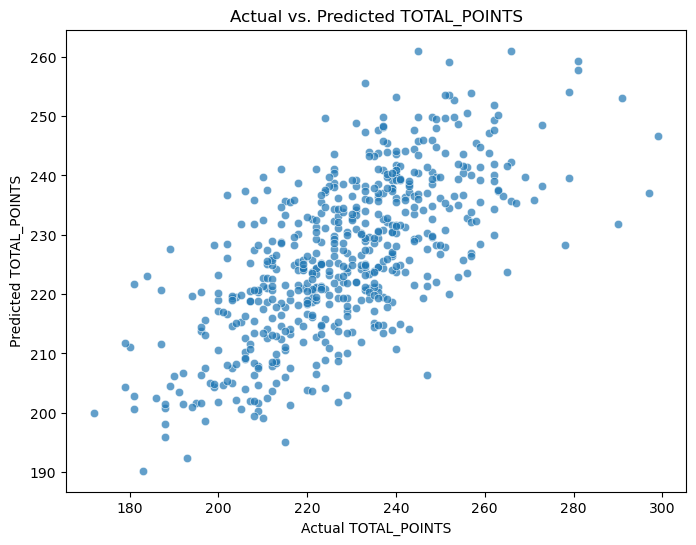

In [25]:
# lets try simple regression models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#defining my independent and dependent variables
# Combine X and y into a single DF temporarily
data = games_merge[['GAME_DATE','TOTAL_AVG_PTS','H_AVG_PTS_L20', 'A_AVG_PTS_L20','H_AVG_AST_L20', 'A_AVG_AST_L20',
                    'H_AVG_REB_L20', 'A_AVG_REB_L20','H_AVG_PACE_L20','A_AVG_PACE_L20','H_DEF_AVG_L20', 'A_DEF_AVG_L20', 
                    'HOME_WIN_STREAK','AWAY_WIN_STREAK','HOME_REST_DAYS','AWAY_REST_DAYS','HOME_WPCT_L10', 'AWAY_WPCT_L10',
                    'HOME_SZN_AVG','AWAY_SZN_AVG', 'H2H_AVG_TOTAL', 'IS_PLAYOFF', 'H_AVG_PTS_L3','A_AVG_PTS_L3',
                    'TOTAL_POINTS']]

# I'm gonna try interaction terms and see if it gives better fit
data = data.copy()
data['ASSIST_INTERACTION'] = data['H_AVG_AST_L20'] * data['A_AVG_AST_L20']
data['ASSIST_COMBINED'] = (data['H_AVG_AST_L20'] + data['A_AVG_AST_L20'])/2
data['PACE_INTERACTION'] = data['H_AVG_PACE_L20'] * data['A_AVG_PACE_L20']
data['TOTAL_PTS_ALLOWED_L20'] = (data['H_DEF_AVG_L20'] + data['A_DEF_AVG_L20'])
data['INTERACTION_1'] = data['H_AVG_PTS_L20'] * data ['A_DEF_AVG_L20']
data['INTERACTION_2'] = data['A_AVG_PTS_L20'] * data ['H_DEF_AVG_L20']
data['REB_COMBINED'] = (data['H_AVG_REB_L20'] + data['A_AVG_REB_L20'])/2
data['REST_DIFF'] = data['HOME_REST_DAYS'] - data['AWAY_REST_DAYS']


# Drop rows with any NaN values in the combined data (model won't take it otherwise)
data = data.dropna()

# Convert GAME_DATE to datetime
data['GAME_DATE'] = pd.to_datetime(data['GAME_DATE'])

# Define the date cutoff for training vs testing
split_date = "2025-02-01" 

# Split into training and testing sets
train_data = data[data['GAME_DATE'] < split_date]
test_data = data[data['GAME_DATE'] >= split_date]




# Separate independent (X) and dependent (y) variables
X_train = train_data[['TOTAL_AVG_PTS', 'TOTAL_PTS_ALLOWED_L20', 'ASSIST_INTERACTION', 'REB_COMBINED', 'HOME_REST_DAYS','AWAY_REST_DAYS',
                       'HOME_SZN_AVG','AWAY_SZN_AVG','H2H_AVG_TOTAL','IS_PLAYOFF', 'H_AVG_PTS_L3','A_AVG_PTS_L3'
                     ]]
y_train = train_data['TOTAL_POINTS']

X_test = test_data[['TOTAL_AVG_PTS', 'TOTAL_PTS_ALLOWED_L20', 'ASSIST_INTERACTION', 'REB_COMBINED', 'HOME_REST_DAYS','AWAY_REST_DAYS',
                    'HOME_SZN_AVG','AWAY_SZN_AVG','H2H_AVG_TOTAL', 'IS_PLAYOFF','H_AVG_PTS_L3','A_AVG_PTS_L3']]
y_test = test_data['TOTAL_POINTS']



# Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)



#evaluate performance
# Predict on test data
y_pred = model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display results
print(data.shape)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-Squared (R²): {r2:.3f}")  

# Print coefficients and intercept
coefficients = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
print(coefficients)
print(f"Intercept: {model.intercept_:.2f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.xlabel("Actual TOTAL_POINTS")
plt.ylabel("Predicted TOTAL_POINTS")
plt.title("Actual vs. Predicted TOTAL_POINTS")
plt.show()



# Daily Predictions

In [27]:
# All of these interacrions are duplicated from when I ran the 'data' df but only now in 'games_merge' df
games_merge['TOTAL_PTS_ALLOWED_L20'] = (games_merge['H_DEF_AVG_L20'] + games_merge['A_DEF_AVG_L20'])
games_merge['ASSIST_INTERACTION'] = games_merge['H_AVG_AST_L20'] *games_merge['A_AVG_AST_L20']
games_merge['REB_COMBINED'] = (games_merge['H_AVG_REB_L20'] + games_merge['A_AVG_REB_L20'])/2



#manually input today matchups daily, look for ways to automate in future
today_matchups = [
    ("MIN","GSW"),
    ("IND","CLE")
     ]

# creating the empty df
prediction_rows = []

# lets for loop through my df values to run through regression
for home, away in today_matchups:
    home_row = games_merge[games_merge['HOME'] == home].sort_values('GAME_DATE').iloc[-1]
    away_row = games_merge[games_merge['AWAY'] == away].sort_values('GAME_DATE').iloc[-1]
    
    row = {
        "TOTAL_AVG_PTS": home_row["TOTAL_AVG_PTS"],
        "TOTAL_PTS_ALLOWED_L20": home_row["TOTAL_PTS_ALLOWED_L20"],
        "ASSIST_INTERACTION": home_row["ASSIST_INTERACTION"],
        "REB_COMBINED": home_row["REB_COMBINED"],
        "HOME_REST_DAYS": home_row["HOME_REST_DAYS"],
        "AWAY_REST_DAYS": away_row["AWAY_REST_DAYS"],
        "HOME_SZN_AVG": home_row["HOME_SZN_AVG"],
        "AWAY_SZN_AVG": away_row["AWAY_SZN_AVG"],
        "H2H_AVG_TOTAL": home_row["H2H_AVG_TOTAL"],   # or from merged later
        "IS_PLAYOFF": home_row["IS_PLAYOFF"],
        "H_AVG_PTS_L3": home_row["H_AVG_PTS_L3"],
        "A_AVG_PTS_L3": away_row["A_AVG_PTS_L3"]
    }
    
    prediction_rows.append(row)

# this table is displaying independent variables for model
today_df = pd.DataFrame(prediction_rows)







predictions = model.predict(today_df)
# This displays the dependent variable
results_df = pd.DataFrame(today_matchups, columns=["HOME", "AWAY"])
results_df["Predicted_Total_Points"] = predictions.round(1)

print(results_df)
print(today_df)
#games_combined.tail()

  HOME AWAY  Predicted_Total_Points
0  MIN  GSW                 211.600
1  IND  CLE                 230.700
   TOTAL_AVG_PTS  TOTAL_PTS_ALLOWED_L20  ASSIST_INTERACTION  REB_COMBINED  \
0        229.700                215.550             715.140        43.600   
1        236.800                228.750             771.420        42.200   

   HOME_REST_DAYS  AWAY_REST_DAYS HOME_SZN_AVG AWAY_SZN_AVG  H2H_AVG_TOTAL  \
0           6.000           2.000        115.1        113.6        210.200   
1           2.000           2.000        118.5        121.7        232.444   

   IS_PLAYOFF  H_AVG_PTS_L3  A_AVG_PTS_L3  
0        True       111.667       108.667  
1        True       117.667       122.000  


# VIF testing for Multicollinearity

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = data[['TOTAL_AVG_PTS', 'TOTAL_PTS_ALLOWED_L20', 'ASSIST_INTERACTION', 
          'REB_COMBINED', 'HOME_REST_DAYS', 'AWAY_REST_DAYS', 
          'HOME_SZN_AVG', 'AWAY_SZN_AVG']].copy()

# Convert all to numeric, coerce errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN or inf values
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Add constant column for intercept
X = sm.add_constant(X)

# Now retry the VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)




                 feature      VIF
0                  const 3048.036
1          TOTAL_AVG_PTS    2.556
2  TOTAL_PTS_ALLOWED_L20    1.120
3     ASSIST_INTERACTION    1.730
4           REB_COMBINED    1.112
5         HOME_REST_DAYS    1.377
6         AWAY_REST_DAYS    1.376
7           HOME_SZN_AVG    1.598
8           AWAY_SZN_AVG    1.534


In [46]:
import os
os.getcwd()


'C:\\Users\\owner'